In [143]:
import pandas as pd
df = pd.read_csv('data/cleaned/merged_house_finance_data_all_years.csv')
df['TTL_DISB'] = df['TTL_DISB'].fillna(0)

In [144]:
df[df['pvi'].isna()].state.value_counts()

Series([], Name: count, dtype: int64)

In [145]:
df = df[~df['party'].isna()]
df

,id,year,state,state_po,district,runoff,special,candidate_name,party,candidate_votes,total_votes,FEC_candidate_id,CAND_ICI,TTL_DISB,NHE,pvi
0,2010AK0,2010,ALASKA,AK,0,NaN,False,DON YOUNG,REPUBLICAN,175384,254335,H6AK00045,I,887310.33,6.8,13.0
1,2010AK0,2010,ALASKA,AK,0,NaN,False,HARRY T CRAWFORD JR,DEMOCRAT,77606,254335,H0AK00089,C,235571.43,6.8,13.0
2,2010AL1,2010,ALABAMA,AL,1,NaN,False,DAVID WALTER,CONSTITUTION,26357,156281,H0AL01048,C,20045.00,6.8,14.0
3,2010AL1,2010,ALABAMA,AL,1,NaN,False,JO BONNER,REPUBLICAN,129063,156281,H2AL01077,I,1101701.00,6.8,14.0
4,2010AL2,2010,ALABAMA,AL,2,NaN,False,BOBBY BRIGHT,DEMOCRAT,106865,219028,H8AL02130,I,1435626.44,6.8,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7689,2020WV3,2020,WEST VIRGINIA,WV,3,False,False,HILARY TURNER,DEMOCRAT,64927,226668,H0WV03151,C,98768.58,-3.1,23.0
7690,2020WY0,2020,WYOMING,WY,0,False,False,JEFF HAGGIT,CONSTITUTION,7905,278503,NaN,NaN,0.00,-3.1,25.0
7691,2020WY0,2020,WYOMING,WY,0,False,False,LIZ CHENEY,REPUBLICAN,185732,278503,H6WY00159,I,3066534.91,-3.1,25.0
7692,2020WY0,2020,WYOMING,WY,0,False,False,LYNNETTE GREY BULL,DEMOCRAT,66576,278503,H0WY01036,C,132285.65,-3.1,25.0


In [146]:
df['percent_of_vote'] = (df['candidate_votes'] / df['total_votes'] * 100).round(2)

In [147]:
# Calculate the difference between the highest and second highest percent_of_vote for each 'id'
df_sorted = df.sort_values(['id', 'percent_of_vote'], ascending=[True, False])
df_top2 = df_sorted.groupby('id').head(2)
df_diff = (-1 * df_top2.groupby('id')['percent_of_vote'].diff()).fillna(0).round(2)
df_margin = df_diff.groupby(df_top2['id']).last().reset_index()
df_margin.columns = ['id', 'vote_margin']

# Merge the vote margin back to the original dataframe
df_with_margin = df.merge(df_margin, on='id', how='left')

In [148]:
df_with_margin['adjusted_vote_margin'] = df_with_margin.apply(lambda row: 
    round(row['vote_margin'] - row['pvi'] - row['NHE'], 2) if row['party'] == 'DEMOCRAT' else
    round(row['vote_margin'] + row['pvi'] + row['NHE'], 2) if row['party'] == 'REPUBLICAN' else
    float('nan'), axis=1)

In [149]:
df_with_margin.columns

Index(['id', 'year', 'state', 'state_po', 'district', 'runoff', 'special',
       'candidate_name', 'party', 'candidate_votes', 'total_votes',
       'FEC_candidate_id', 'CAND_ICI', 'TTL_DISB', 'NHE', 'pvi',
       'percent_of_vote', 'vote_margin', 'adjusted_vote_margin'],
      dtype='object')

In [150]:
df_with_margin = df_with_margin[['id', 'year', 'state', 'state_po', 'district', 'runoff', 'special',
       'candidate_name', 'party', 'CAND_ICI', 'TTL_DISB', 'adjusted_vote_margin', 'candidate_votes', 'total_votes', 'NHE', 'pvi',
       'percent_of_vote', 'vote_margin',
       'FEC_candidate_id']]

df_with_margin['party'] = df_with_margin['party'].apply(lambda x: 'Democrat' if x.lower() == 'democrat' else 'Republican' if x.lower() == 'republican' else 'Other')

In [151]:
df_with_margin.to_csv('data/cleaned/all_final.csv', index=False)

In [161]:
df_with_margin[(df_with_margin['year'] == 2014) & (df_with_margin['state_po'] == 'AK') & (df_with_margin['district'] == 0)]

,id,year,state,state_po,district,runoff,special,candidate_name,party,CAND_ICI,TTL_DISB,adjusted_vote_margin,candidate_votes,total_votes,NHE,pvi,percent_of_vote,vote_margin,FEC_candidate_id
2554,2014AK0,2014,ALASKA,AK,0,NaN,False,DON YOUNG,Republican,I,809039.20,27.7,142572,279741,5.7,12.0,50.97,10.0,H6AK00045
2555,2014AK0,2014,ALASKA,AK,0,NaN,False,FORREST DUNBAR,Democrat,C,230088.83,-7.7,114602,279741,5.7,12.0,40.97,10.0,H4AK00123
2556,2014AK0,2014,ALASKA,AK,0,NaN,False,JIM C MCDERMOTT,Other,C,7877.00,NaN,21290,279741,5.7,12.0,7.61,10.0,H2AK00143


# taking the most contested races

In [152]:
df_subset = df_with_margin[df_with_margin['adjusted_vote_margin'].abs() < 10]
df_subset = df_subset[df_subset['year'] >= 2012]

df_subset['district_id'] = df_subset['state_po'] + df_subset['district'].astype(str)
df_subset.drop(columns=['state_po', 'district'], inplace=True)

df_subset = df_subset[['id', 'district_id', 'year', 'state', 'runoff', 'special', 'candidate_name', 'party',
       'CAND_ICI', 'TTL_DISB', 'adjusted_vote_margin', 'candidate_votes',
       'total_votes', 'NHE', 'pvi', 'percent_of_vote', 'vote_margin',
       'FEC_candidate_id']]

df_subset.sort_values(['district_id', 'year'], inplace=True)

In [153]:
len(df_subset)

808

In [154]:
# all_total = 0
# for year in df_subset['year'].unique():
#     yearly_total = 0
#     for state in df_subset['state'].unique():
#         number_of_districts = len(df_subset[(df_subset['year'] == year) & (df_subset['state'] == state)]['district'].unique())
#         yearly_total += number_of_districts
#         # print(year, state, number_of_districts)
#     all_total += yearly_total
#     print(year, yearly_total)
# print(all_total)


In [155]:
# Group by district_id and filter out districts with only one unique year
districts_to_keep = df_subset.groupby('district_id')['year'].nunique() > 1
df_subset = df_subset[df_subset['district_id'].isin(districts_to_keep[districts_to_keep].index)]

In [156]:
len(df_subset)

727

In [157]:
df_subset.to_csv('data/cleaned/most_contested_races.csv', index=False)

# graphs

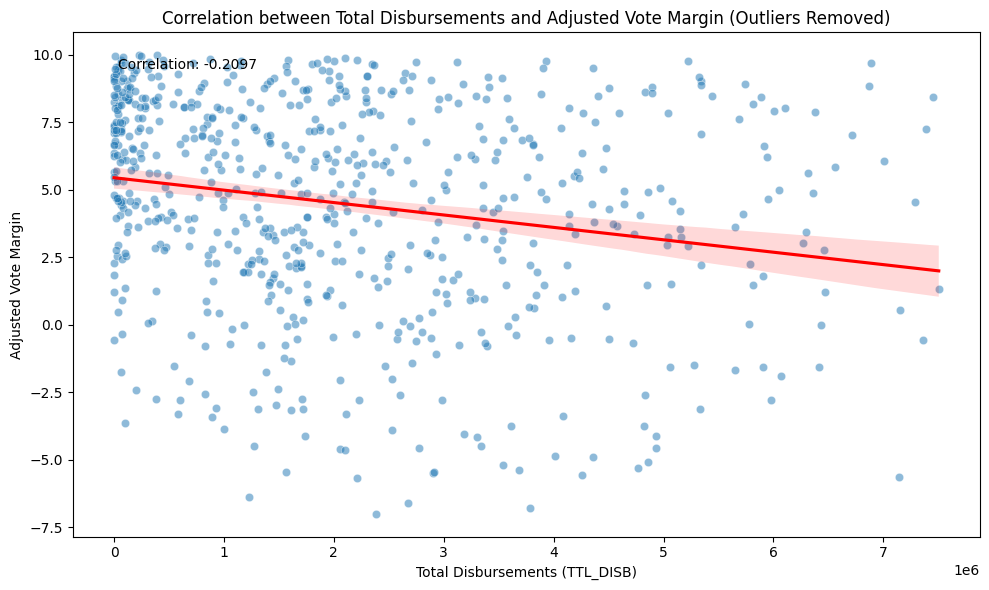

Correlation between TTL_DISB and adjusted_vote_margin (outliers removed): -0.2097
Number of data points removed as outliers: 32


In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from both TTL_DISB and adjusted_vote_margin
df_no_outliers = remove_outliers(df_subset, 'TTL_DISB')
df_no_outliers = remove_outliers(df_no_outliers, 'adjusted_vote_margin')

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='TTL_DISB', y='adjusted_vote_margin', alpha=0.5)

# Add a regression line
sns.regplot(data=df_no_outliers, x='TTL_DISB', y='adjusted_vote_margin', scatter=False, color='red')

# Set labels and title
plt.xlabel('Total Disbursements (TTL_DISB)')
plt.ylabel('Adjusted Vote Margin')
plt.title('Correlation between Total Disbursements and Adjusted Vote Margin (Outliers Removed)')

# Calculate and display the correlation coefficient
correlation = df_no_outliers['TTL_DISB'].corr(df_no_outliers['adjusted_vote_margin'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the correlation coefficient and the number of removed outliers
print(f"Correlation between TTL_DISB and adjusted_vote_margin (outliers removed): {correlation:.4f}")
print(f"Number of data points removed as outliers: {len(df_subset) - len(df_no_outliers)}")


/tmp/ipykernel_60963/3856747313.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


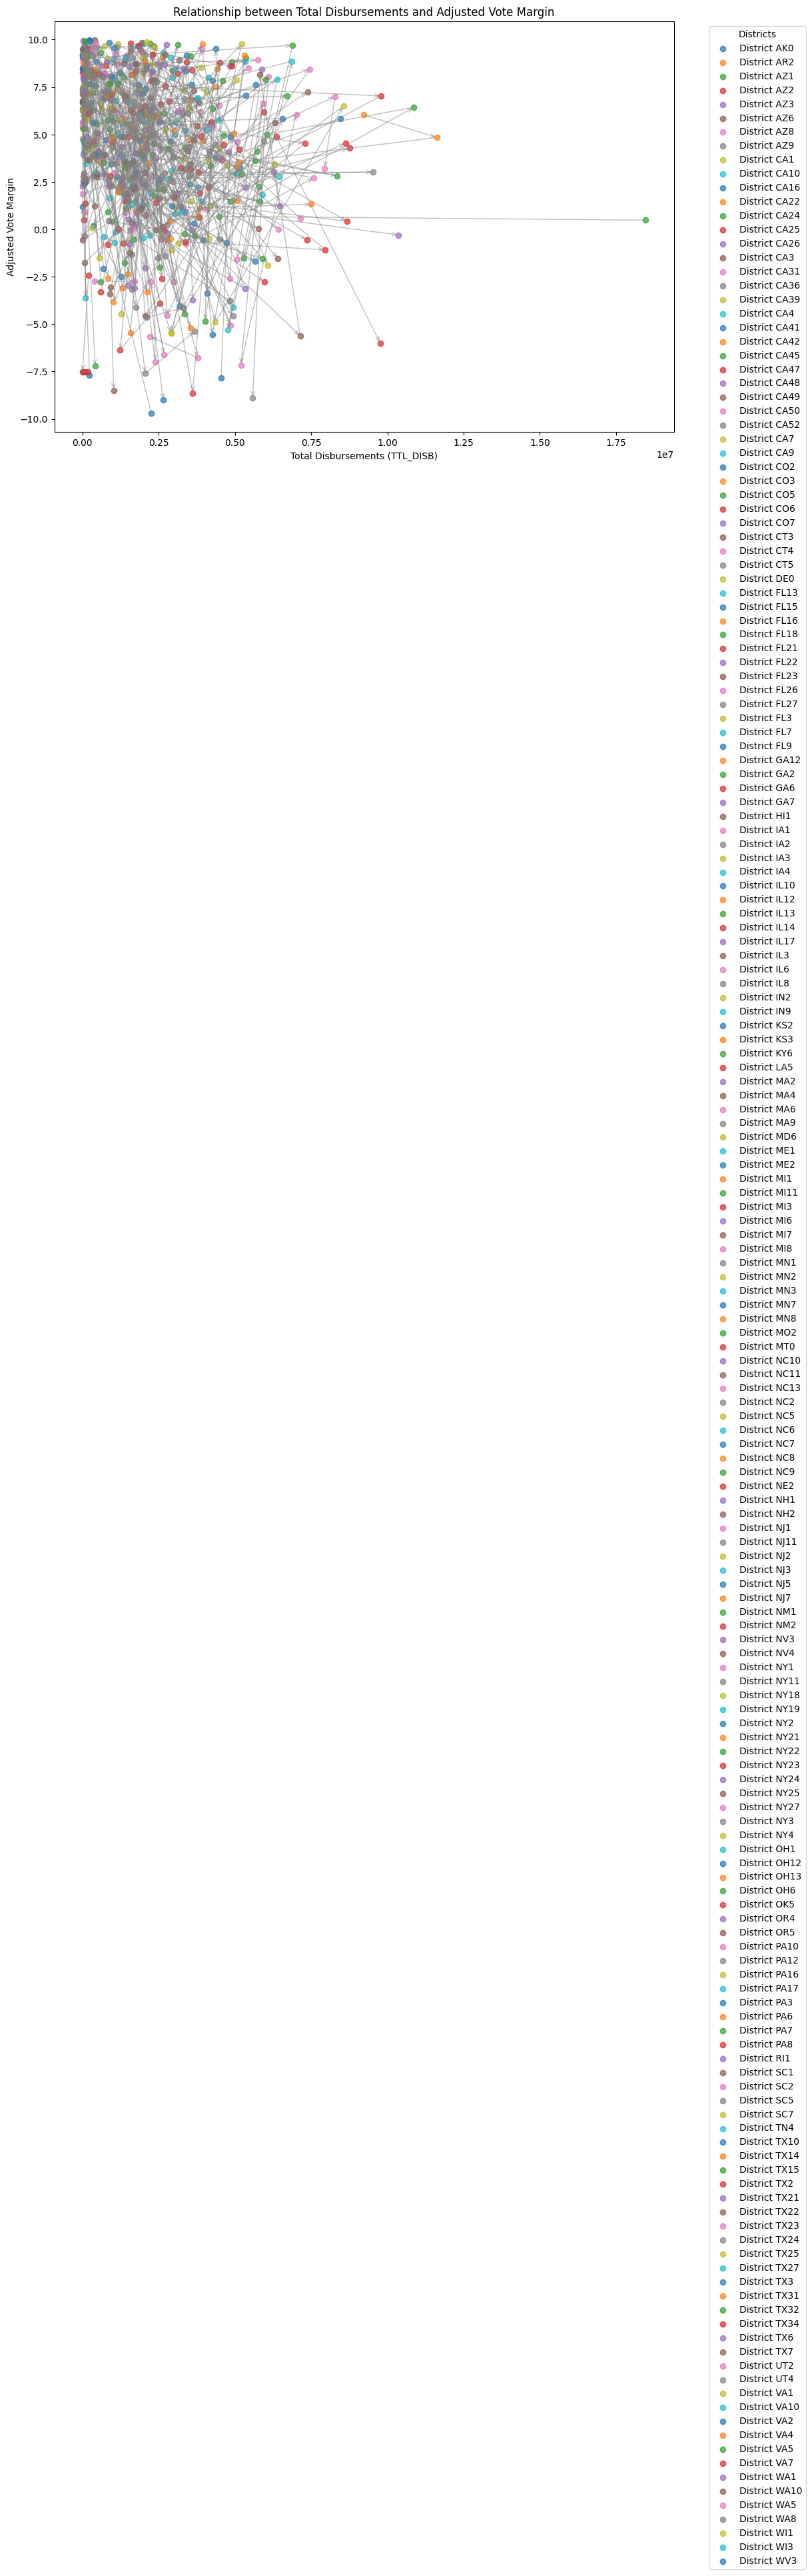

Overall correlation between TTL_DISB and adjusted_vote_margin: -0.1765


In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by district_id
grouped = df_subset.groupby('district_id')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate through each district and plot its data
for district_id, group in grouped:
    ax.scatter(group['TTL_DISB'], group['adjusted_vote_margin'], 
               label=f'District {district_id}', alpha=0.7)
    
    # Add arrows to show the progression over years
    for i in range(len(group) - 1):
        ax.annotate('', xy=(group['TTL_DISB'].iloc[i+1], group['adjusted_vote_margin'].iloc[i+1]),
                    xytext=(group['TTL_DISB'].iloc[i], group['adjusted_vote_margin'].iloc[i]),
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

# Set labels and title
ax.set_xlabel('Total Disbursements (TTL_DISB)')
ax.set_ylabel('Adjusted Vote Margin')
ax.set_title('Relationship between Total Disbursements and Adjusted Vote Margin')

# Add a legend
ax.legend(title='Districts', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df_subset['TTL_DISB'].corr(df_subset['adjusted_vote_margin'])
print(f"Overall correlation between TTL_DISB and adjusted_vote_margin: {correlation:.4f}")
